In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-02-25 04:34:23--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-02-25 04:34:23 (8.41 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



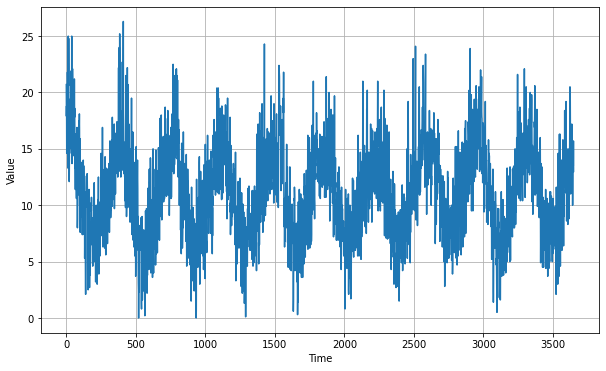

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  sun_spot = csv.reader(csvfile, delimiter=',')
  next(sun_spot)
  steps = 0
  for row in sun_spot:
    time_step.append(steps)
    temps.append(float(row[1]))
    steps += 1



series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x: x.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, activation='relu', padding='causal', input_shape=[None, 1]),
                                    #tf.keras.layers.LSTM(64, return_sequences=True),
                                    #tf.keras.layers.LSTM(50, return_sequences=True),
                                    tf.keras.layers.LSTM(80, return_sequences=True),
                                    tf.keras.layers.LSTM(50, return_sequences=True),
                                    #tf.keras.layers.Lambda(lambda x: x*1000),
                                    tf.keras.layers.Dense(60, activation='relu'),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


In [14]:
np.min(history.history['mae'])

2.2043488025665283

(1e-08, 0.0001, 0.0, 60.0)

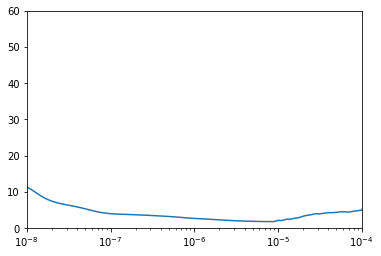

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, activation='relu', padding='causal', input_shape=[None, 1]),
                                    #tf.keras.layers.LSTM(64, return_sequences=True),
                                    #tf.keras.layers.LSTM(50, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    #tf.keras.layers.Lambda(lambda x: x*1000),
                                    #tf.keras.layers.Dense(60, activation='relu'),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400) 
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs= 500)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
25/25 [==============================] - 3s 15ms/step - loss: 65.9401 - mae: 66.4372
Epoch 2/500
25/25 [==============================] - 0s 15ms/step - loss: 5.2388 - mae: 5.7237
Epoch 3/500
25/25 [==============================] - 0s 14ms/step - loss: 2.3926 - mae: 2.8552
Epoch 4/500
25/25 [==============================] - 0s 13ms/step - loss: 1.9959 - mae: 2.4525
Epoch 5/500
25/25 [==============================] - 0s 13ms/step - loss: 1.9048 - mae: 2.3598
Epoch 6/500
25/25 [==============================] - 0s 13ms/step - loss: 1.8480 - mae: 2.3022
Epoch 7/500
25/25 [==============================] - 0s 13ms/step - loss: 1.8075 - mae: 2.2604
Epoch 8/500
25/25 [==============================] - 0s 14ms/step - loss: 1.7858 - mae: 2.2369
Epoch 9/500
25/25 [==============================] - 0s 15ms/step - loss: 1.7674 - mae: 2.2180
Epoch 10/500
25/25 [==============================] - 0s 14ms/step - loss: 1.7357 - mae: 2.1850
Epoch 11/500
25/25 [===========================

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

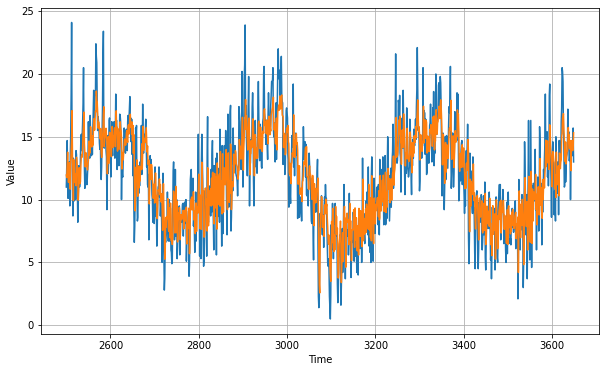

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7863281

In [20]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.278576 11.17773  12.075593 ... 12.995466 13.139686 14.37712 ]
